In [112]:
import pysam
import matplotlib.pyplot as plt
import ternary
import numpy as np
from scipy.stats import chi2
import pandas as pd
import joblib
from collections import defaultdict

import numpy as np
from scipy.stats import chi2

def chi_sq_hwe(X, x_linked=False, pvalues=True):
    if isinstance(X, np.ndarray) and X.ndim == 1:
        X = np.reshape(X, (1, len(X)))
    if not x_linked:
        # autosomal
        X = X[:, np.argsort(np.sum(X, axis=0))]  # order.auto function equivalent
        n = np.sum(X, axis=1)
        nA = 2 * X[:, 0] + X[:, 1]
        nB = 2 * X[:, 2] + X[:, 1]
        chi = (4 * X[:, 0] * X[:, 2] - X[:, 1]**2) / (nA * nB)
        if pvalues:
            stat = chi2.sf(n * chi**2, 1)  # pchisq function equivalent
        else:
            stat = n * chi**2
    else:
        # X chromosomal
        X = X[:, np.argsort(X[0])]  # order.x function equivalent
        nm = X[:, 0] + X[:, 1]
        nA = X[:, 0] + 2 * X[:, 2] + X[:, 3]
        nA2 = nA**2
        nf = X[:, 2] + X[:, 3] + X[:, 4]
        nt = nm + 2 * nf
        nB = nt - nA
        nB2 = nB**2
        m_num = nA * X[:, 1] - nB * X[:, 0]
        X_male = (m_num**2) / (nm * nA * nB)
        f_num = nt**2 * (X[:, 2]**2 * nB2 + 0.5 * X[:, 3]**2 * nA * nB + X[:, 4]**2 * nA2) - nf**2 * nA2 * nB2
        X_female = f_num / (nf * nA2 * nB2)
        if pvalues:
            stat = chi2.sf(X_male + X_female, 2)
        else:
            stat = X_male + X_female
    return stat

def parse_vcf(vcf_file):
    vcf = pysam.VariantFile(vcf_file)
    genotype_counts = []
    for record in vcf:
        if record.chrom == 'chrX' or record.chrom == 'chrY':
            continue
        hom_ref, het, hom_alt = 0, 0, 0
        for sample in record.samples.values():
            if None in sample['GT']:
                continue
            ac = sample['GT'].count(1)
            if ac == 0:
                hom_ref += 1
            elif ac == 1:
                het += 1
            elif ac == 2:
                hom_alt += 1
        genotype_counts.append((hom_ref, het, hom_alt))
    return genotype_counts

def calculate_genotype_frequencies(genotype_counts, p_values, alpha=0.05):
    accept_genotype_frequencies = []
    reject_genotype_frequencies = []
    for (hom_ref, het, hom_alt, missing), pval in zip(genotype_counts, p_values):
        total = hom_ref + het + hom_alt
        if total == 0 or missing / (total + missing) >= 0.1:
            continue

        freq_hom_ref = hom_ref / total
        freq_het = het / total
        freq_hom_alt = hom_alt / total
        if pval <= alpha:
            reject_genotype_frequencies.append((freq_hom_ref, freq_het, freq_hom_alt))
        else:
            accept_genotype_frequencies.append((freq_hom_ref, freq_het, freq_hom_alt))
    return accept_genotype_frequencies, reject_genotype_frequencies

def hwe_ternary(genotype_counts, alpha=0.05, title=""):    
    pvals = chi_sq_hwe(genotype_counts[:,:3].astype(int))
    ref_mon = np.isnan(pvals)
    
    m_tot = genotype_counts.sum(axis=1)
    missing_rate = genotype_counts[:,3] / m_tot
    high_missing = missing_rate >= 0.1
    
    filt = pvals[~ref_mon & ~high_missing]
    analyzed = len(filt)
    hwe_pass = (filt>=alpha).sum()

    ret = pd.DataFrame([[len(genotype_counts), 
                     ref_mon.sum(), 
                     high_missing.sum(),
                     analyzed,
                     hwe_pass,
                    hwe_pass / analyzed]], 
                    columns=['Total', 'RefMon', "Missing", "Analyzed", "PassHWE", "Pass%"])
    
    green_genotype_frequencies, red_genotype_frequencies = calculate_genotype_frequencies(genotype_counts, pvals, alpha)
    # Set up the figure and axes
    figure, tax = ternary.figure(scale=1)
    tax.boundary(linewidth=2.0)
    tax.gridlines(multiple=0.1, color="blue")

    # Define the vertices of the triangle
    tax.left_axis_label("p^2", offset=0.08)
    tax.right_axis_label("q^2", offset=0.08)
    tax.bottom_axis_label("2pq", offset=0.05)
    
    tax.left_corner_label("REF", offset=0.20)
    tax.top_corner_label("HET", offset=0.13)
    tax.right_corner_label("HOM", offset=0.20)

    # Plot a Hardy-Weinberg Equilibrium line
    p_values = [i/100.0 for i in range(101)]
    points = [(p**2, 2*p*(1-p), (1-p)**2) for p in p_values]
    tax.plot(points, linewidth=3.0, color='black')

    # Add points for variants
    tax.scatter(green_genotype_frequencies, marker='o', color='green', s=10, alpha=0.75)
    tax.scatter(red_genotype_frequencies, marker='o', color='red', s=10, alpha=0.75)    
    
    # Customize the plot
    tax.set_title(title)
    tax.get_axes().axis('off')
    tax.clear_matplotlib_ticks()

    # Show the plot
    plt.show()
    
    return ret, green_genotype_frequencies + red_genotype_frequencies

In [142]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def create_cool_to_warm_colormap():
    # Define the gradient from blue to red with a smooth white center
    cdict = {
        'red':   [(0.0, 0.0, 0.0),   # blue at low end
                  (0.5, 1.0, 1.0),   # white at the middle
                  (1.0, 1.0, 1.0)],  # red at the high end
                  
        'green': [(0.0, 0.0, 0.0),   # blue at low end
                  (0.5, 1.0, 1.0),   # white in the middle
                  (1.0, 0.0, 0.0)],  # red at the high end
                  
        'blue':  [(0.0, 1.0, 1.0),   # blue at low end
                  (0.5, 1.0, 1.0),   # white in the middle
                  (1.0, 0.0, 0.0)]   # no blue at the high end
    }
    
    # Create and return the colormap
    return LinearSegmentedColormap('CoolToWarm', cdict)


# Create the colormap
cmap = create_cool_to_warm_colormap()


import matplotlib.pyplot as plt
import ternary
from collections import defaultdict
from ternary.helpers import simplex_iterator
import math

# Your observed data points
def plot2(data_points, scale=50, vmin=0, vmax=1, title='density', norm='none'):
    """
    norm one of none, pct, or log
    """
    # Define the function to create heatmap data based on observed points
    def generate_heatmap_data(data_points, scale=5):
        # Create a density dictionary
        density_dict = defaultdict(int)

        # Count occurrences of data points
        for (x, y, z) in data_points:
            # Round x and y to the appropriate scale to determine the bin
            bin_key = (round(x * scale), round(y * scale))
            density_dict[bin_key] += 1

        # Now, create a density dictionary with simplex bins
        final_density_dict = {}
        for (i, j, k) in simplex_iterator(scale):
            bin_key = (i, j)
            final_density_dict[bin_key] = density_dict.get(bin_key, 0)
        if norm == 'pct':
            total = sum(final_density_dict.values())
            for i in final_density_dict:
                final_density_dict[i] = final_density_dict[i] / total
        elif norm == 'log':
            for i in final_density_dict:
                v = final_density_dict[i]
                if v == 0:
                    final_density_dict[i] = None
                else:
                    final_density_dict[i] = math.log(v)

        return final_density_dict

    # Set the scale
    # Generate heatmap data
    d = generate_heatmap_data(data_points, scale)

    # Create the ternary plot
    figure, tax = ternary.figure(scale=scale)
    figure.set_size_inches(12, 8)
    # Create the heatmap
    p_values = [i/100.0 for i in range(101)]
    points = [(p**2 * scale, 2*p*(1-p) * scale, (1-p)**2 * scale) for p in p_values]
    tax.plot(points, linewidth=1.0, color='black')
    
    #tax.gridlines(multiple=5, color="blue")

    # Define the vertices of the triangle
    tax.left_axis_label("p^2", offset=0.08)
    tax.right_axis_label("q^2", offset=0.08)
    tax.bottom_axis_label("2pq", offset=0.05)
    
    tax.left_corner_label("REF", offset=0.20)
    tax.top_corner_label("HET", offset=0.13)
    tax.right_corner_label("HOM", offset=0.20)
    
    
    tax.heatmap(d, style="h", vmin=vmin, vmax=vmax)  # Use 'h' style for hexagonal heatmap
    tax.boundary()
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')
    tax.set_title(title)

    # Show the plot
    plt.rcParams['pdf.fonttype'] = 42
    plt.savefig(title + '.pdf', format='pdf', bbox_inches='tight')


/Users/english/py/lib/python3.9/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


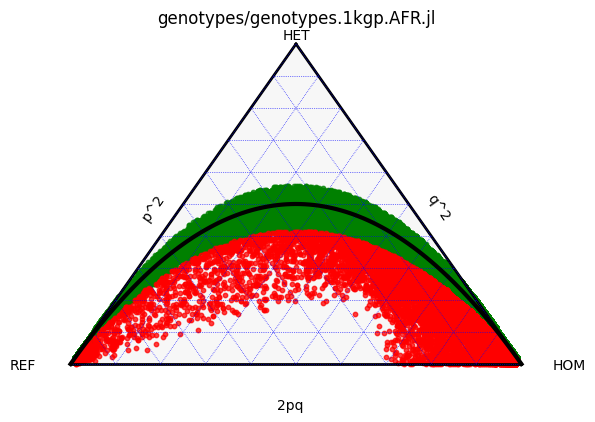

/Users/english/py/lib/python3.9/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


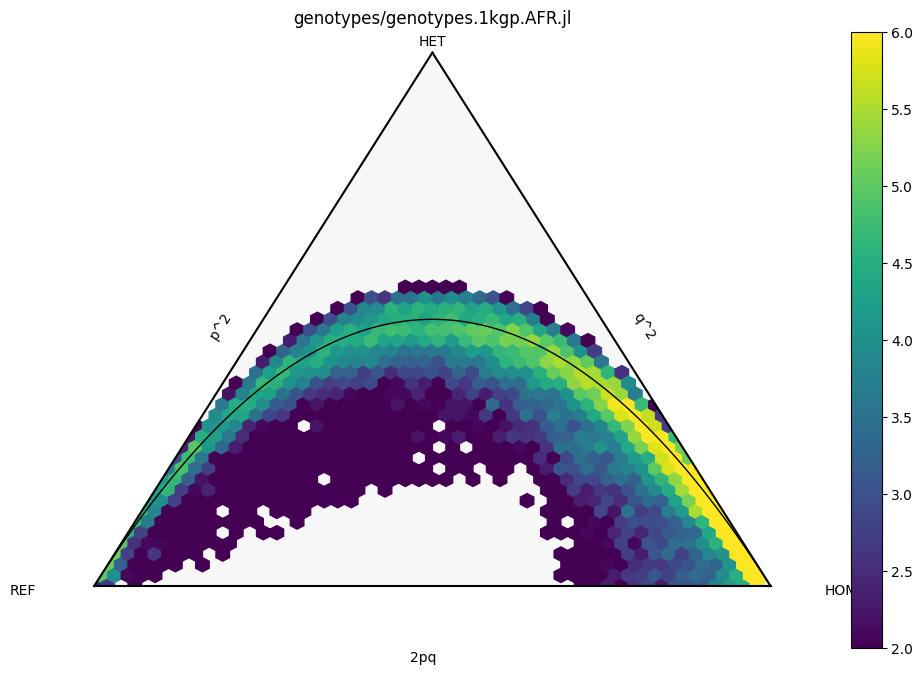

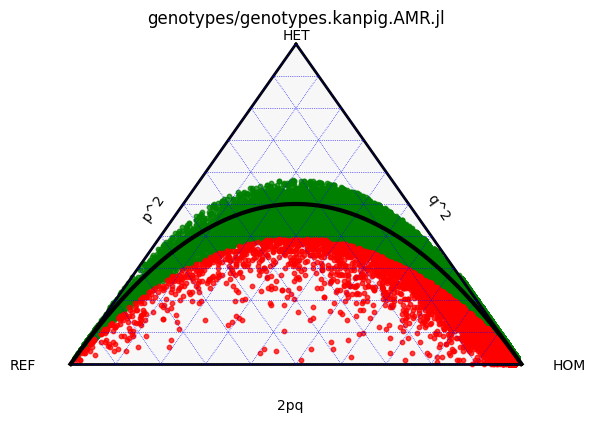

/Users/english/py/lib/python3.9/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


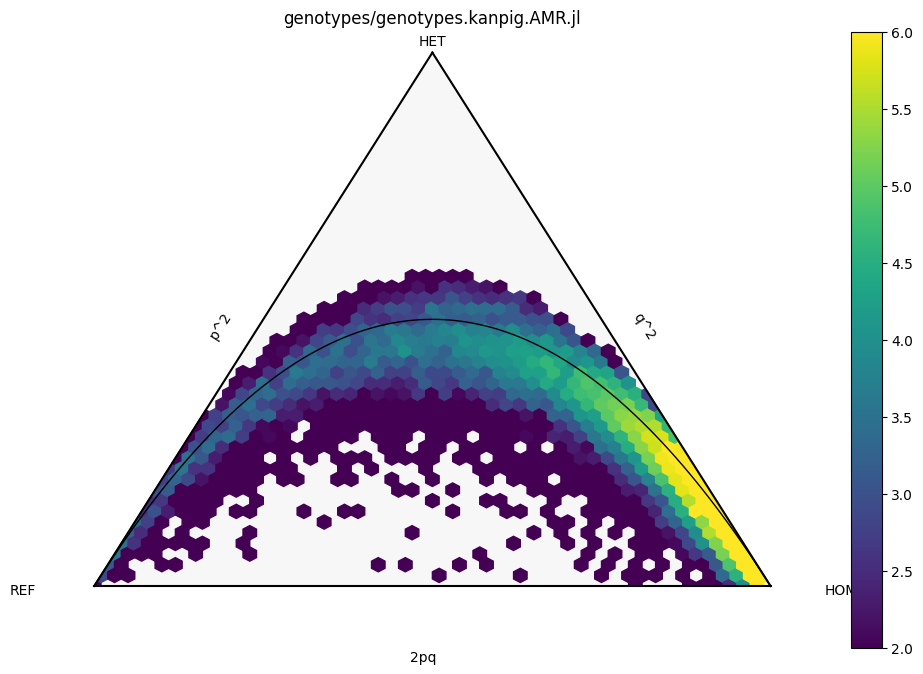

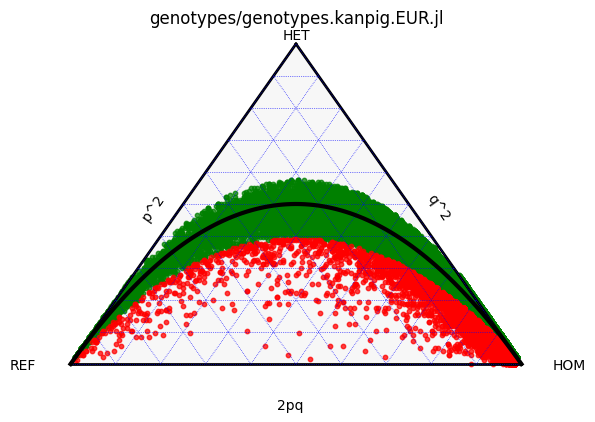

/Users/english/py/lib/python3.9/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


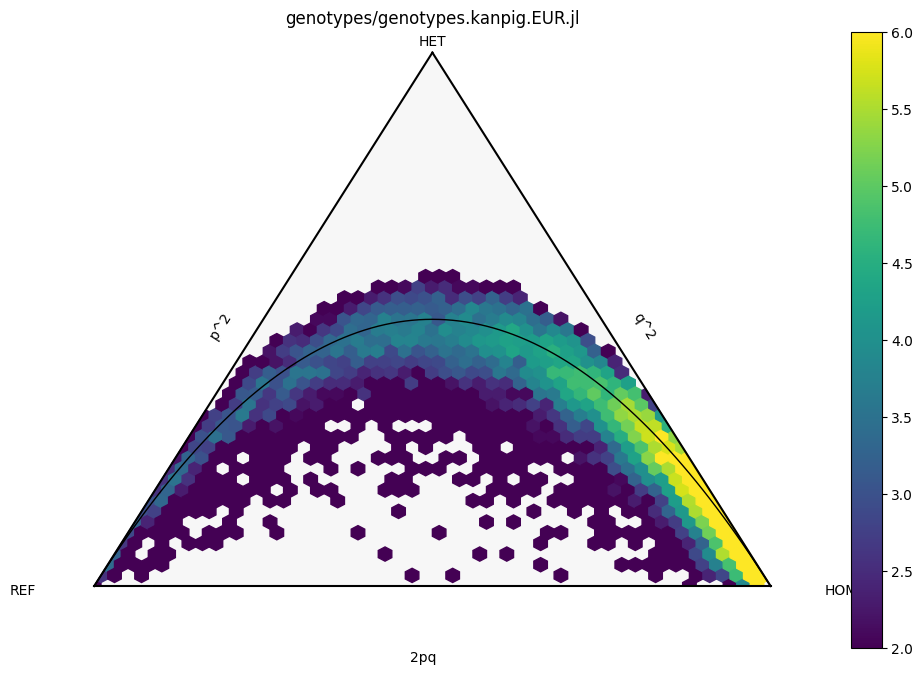

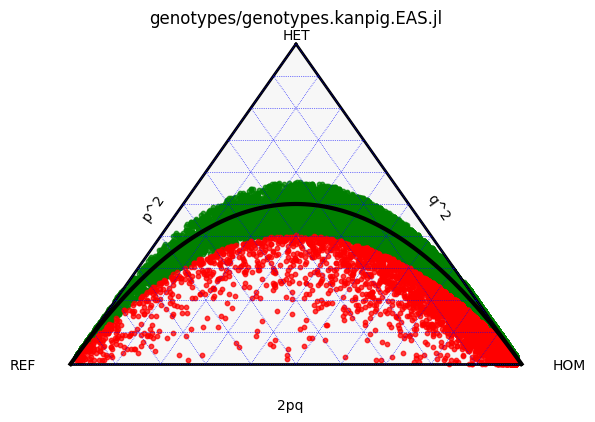

/Users/english/py/lib/python3.9/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


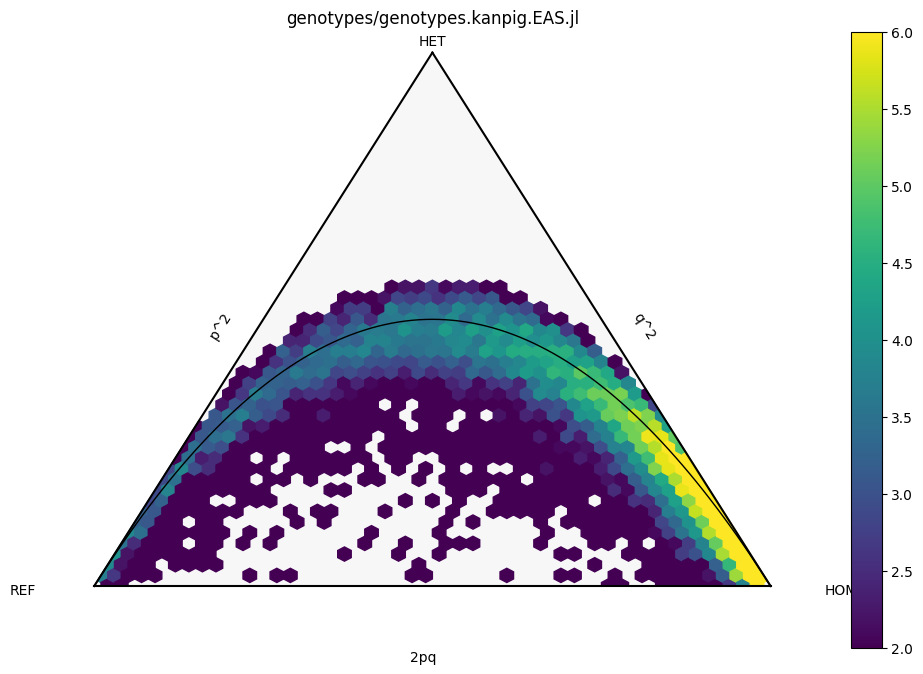

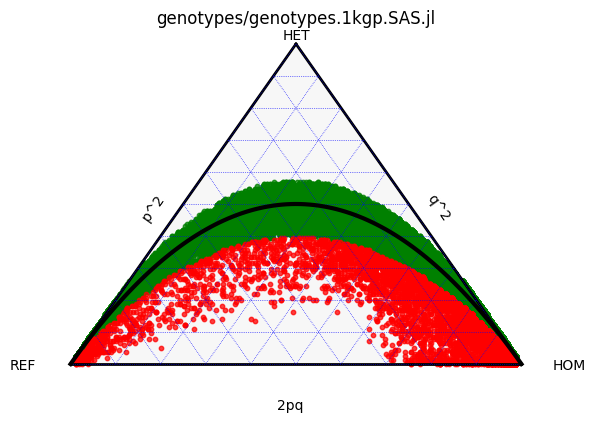

/Users/english/py/lib/python3.9/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


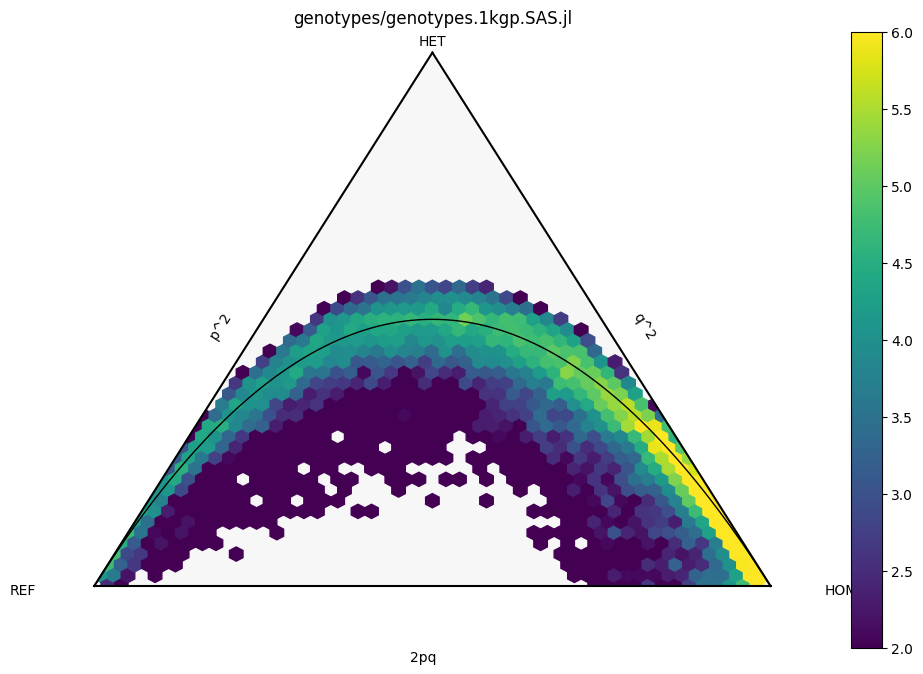

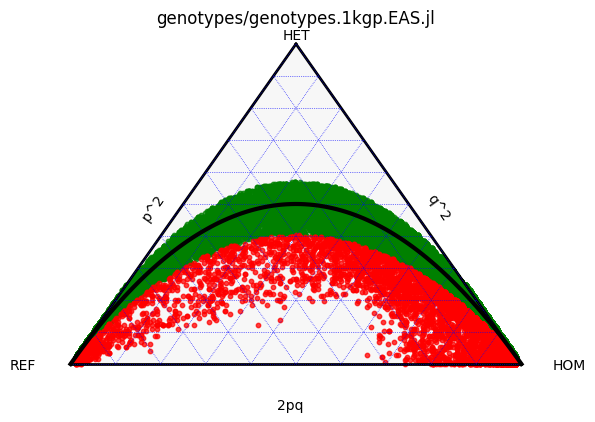

/Users/english/py/lib/python3.9/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


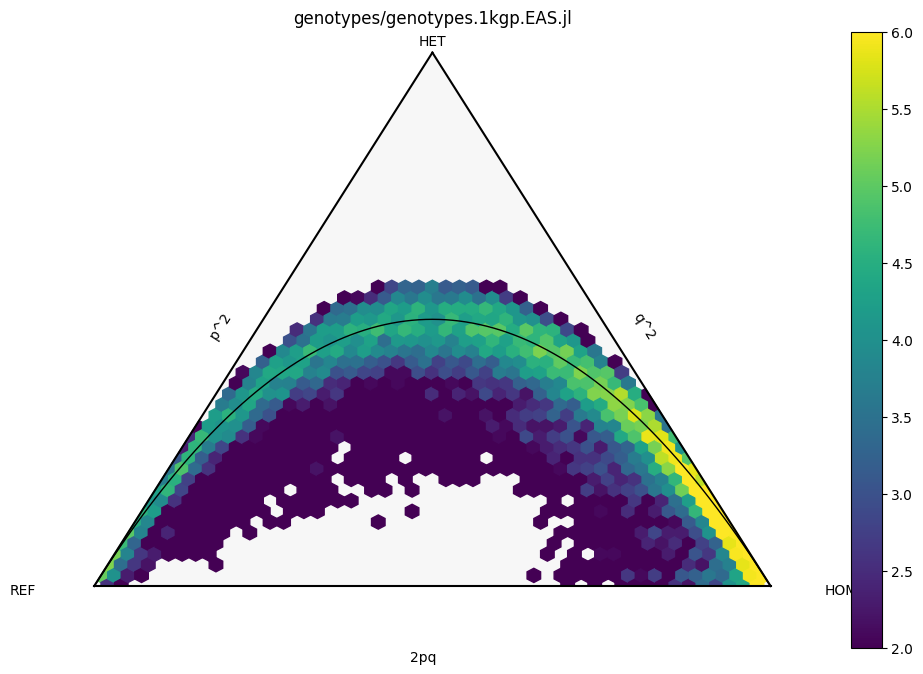

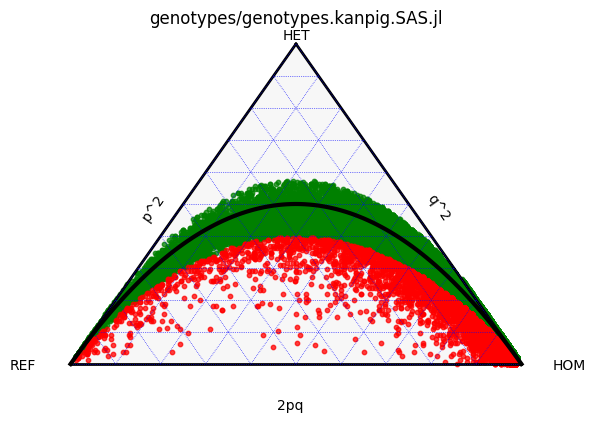

/Users/english/py/lib/python3.9/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


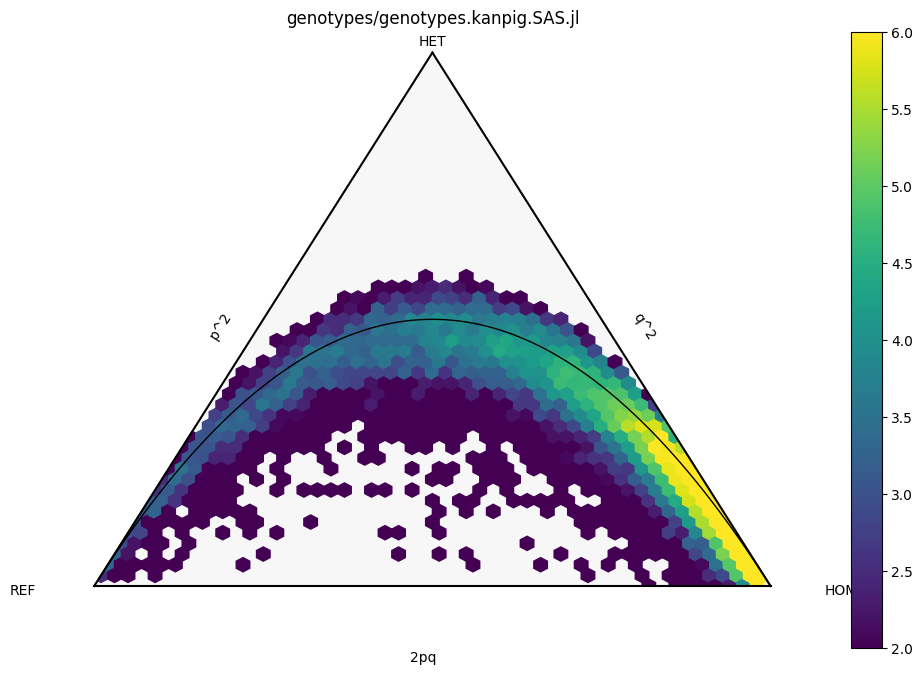

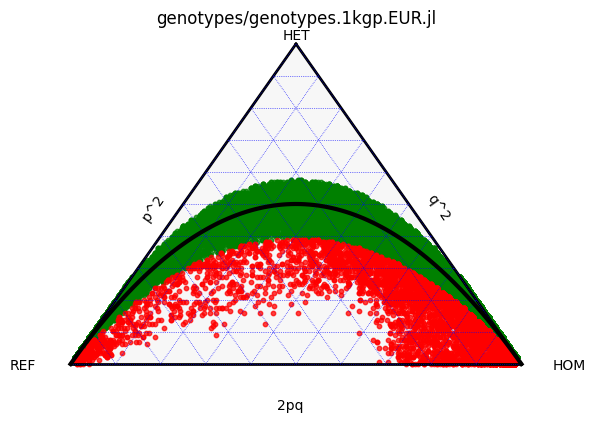

/Users/english/py/lib/python3.9/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


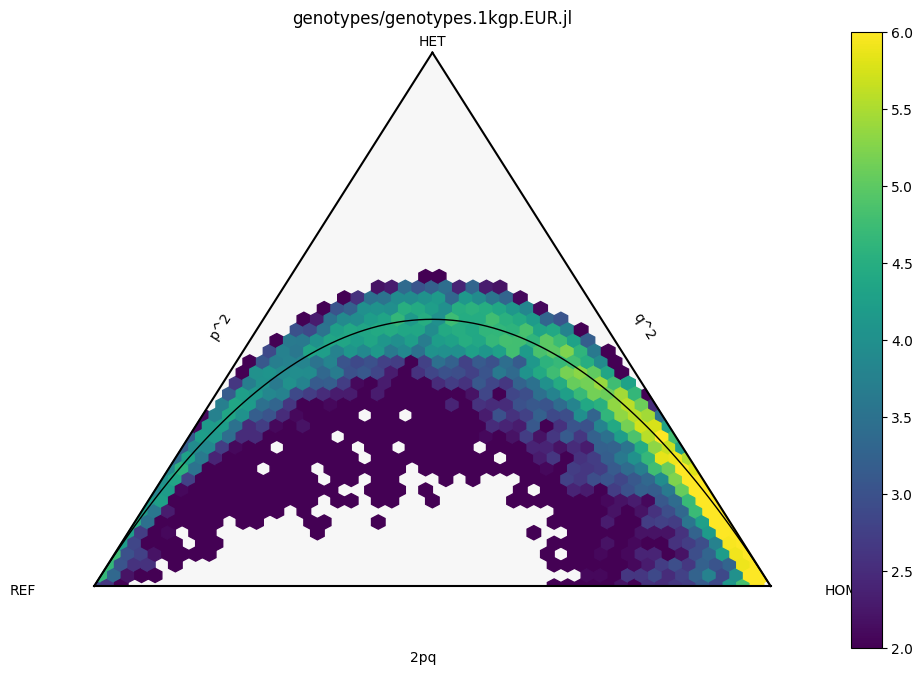

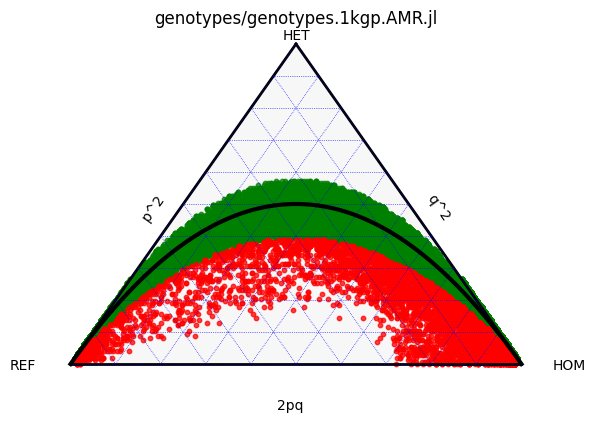

/Users/english/py/lib/python3.9/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


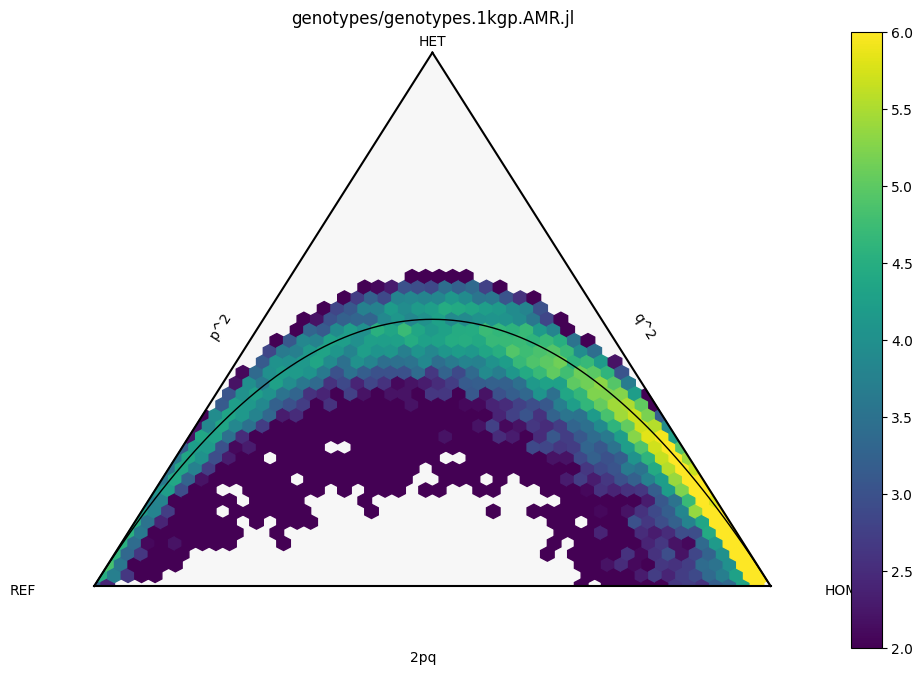

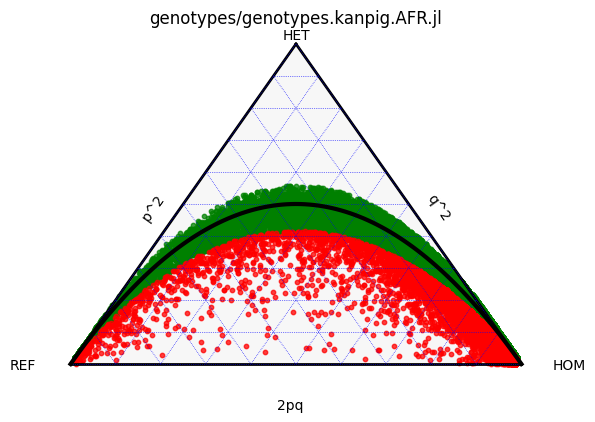

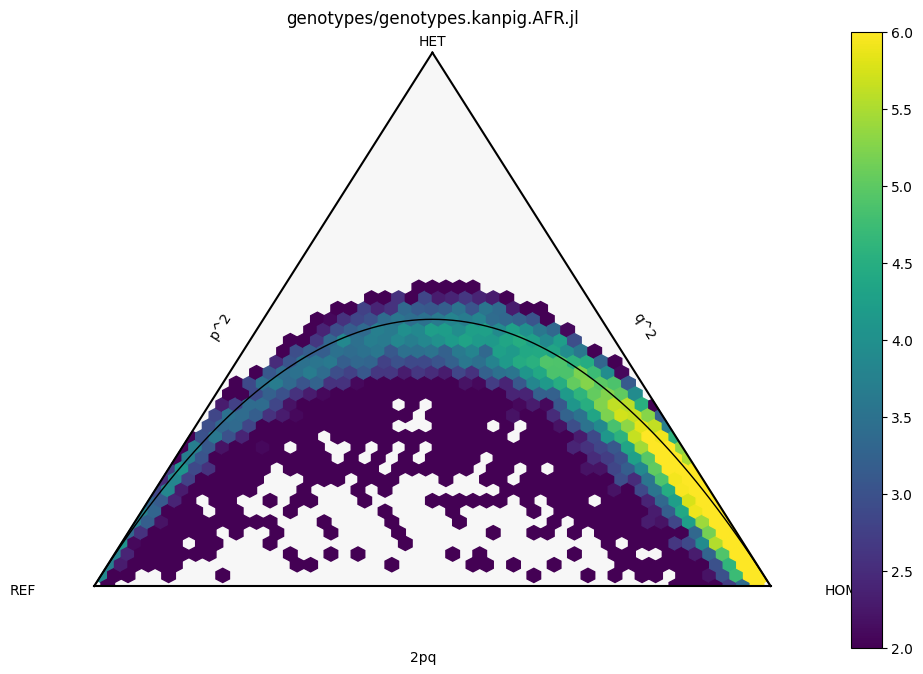

In [143]:
import glob
parts = []
for i in glob.glob("genotypes/*jl"):
    gt_snif = joblib.load(i)
    summary, data = hwe_ternary(gt_snif, title=i, alpha=0.01)
    plot2(data, 50, vmin=2, vmax=6, title=i, norm='log')
    summary['file'] = i
    parts.append(summary)

In [130]:
d = pd.concat(parts)
d['Program'] = d['file'].apply(lambda x: x.split('.')[1])
d['Super Population'] = d['file'].apply(lambda x: x.split('.')[2])
                               

In [132]:
d

,Total,RefMon,Missing,Analyzed,PassHWE,Pass%,file,Program,Super Population
0,72771,0,0,72771,60687,0.833945,genotypes/genotypes.1kgp.AFR.jl,1kgp,AFR
0,157165,0,0,157165,127237,0.809576,genotypes/genotypes.kanpig.AMR.jl,kanpig,AMR
0,146004,0,0,146004,120793,0.827327,genotypes/genotypes.kanpig.EUR.jl,kanpig,EUR
0,126212,0,0,126212,98865,0.783325,genotypes/genotypes.kanpig.EAS.jl,kanpig,EAS
0,50872,0,0,50872,43622,0.857485,genotypes/genotypes.1kgp.SAS.jl,1kgp,SAS
0,46741,0,0,46741,39723,0.849853,genotypes/genotypes.1kgp.EAS.jl,1kgp,EAS
0,122840,0,0,122840,97957,0.797436,genotypes/genotypes.kanpig.SAS.jl,kanpig,SAS
0,51384,0,0,51384,44407,0.864218,genotypes/genotypes.1kgp.EUR.jl,1kgp,EUR
0,57518,0,0,57518,48895,0.850082,genotypes/genotypes.1kgp.AMR.jl,1kgp,AMR
0,178304,0,0,178304,140524,0.788115,genotypes/genotypes.kanpig.AFR.jl,kanpig,AFR


In [137]:
d

,Total,RefMon,Missing,Analyzed,PassHWE,Pass%,file,Program,Super Population,Violate HWE
0,72771,0,0,72771,60687,0.833945,genotypes/genotypes.1kgp.AFR.jl,1kgp,AFR,0
0,157165,0,0,157165,127237,0.809576,genotypes/genotypes.kanpig.AMR.jl,kanpig,AMR,0
0,146004,0,0,146004,120793,0.827327,genotypes/genotypes.kanpig.EUR.jl,kanpig,EUR,0
0,126212,0,0,126212,98865,0.783325,genotypes/genotypes.kanpig.EAS.jl,kanpig,EAS,0
0,50872,0,0,50872,43622,0.857485,genotypes/genotypes.1kgp.SAS.jl,1kgp,SAS,0
0,46741,0,0,46741,39723,0.849853,genotypes/genotypes.1kgp.EAS.jl,1kgp,EAS,0
0,122840,0,0,122840,97957,0.797436,genotypes/genotypes.kanpig.SAS.jl,kanpig,SAS,0
0,51384,0,0,51384,44407,0.864218,genotypes/genotypes.1kgp.EUR.jl,1kgp,EUR,0
0,57518,0,0,57518,48895,0.850082,genotypes/genotypes.1kgp.AMR.jl,1kgp,AMR,0
0,178304,0,0,178304,140524,0.788115,genotypes/genotypes.kanpig.AFR.jl,kanpig,AFR,0


/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_2260/1191194512.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels([int(_.get_text()) // 1000 for _ in p.get_yticklabels()])


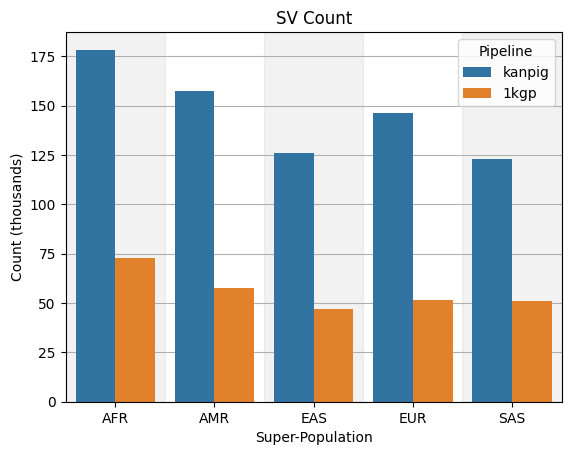

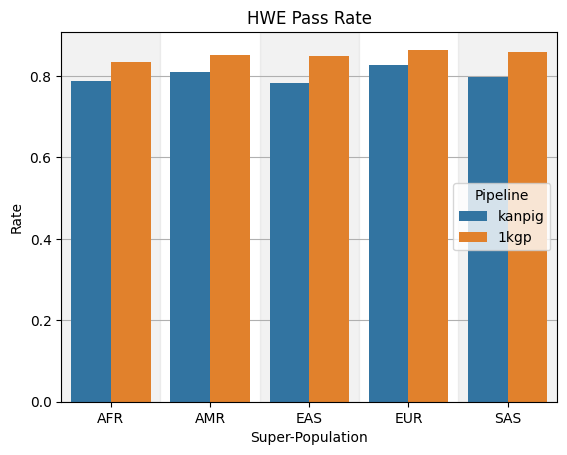

In [175]:
import seaborn as sb
import matplotlib.pyplot as plt
d['Violate HWE'] = d['Analyzed'] - d['PassHWE'] 
d['Pipeline'] = d['Program']
p = sb.barplot(data=d, x="Super Population", y="Total",
               zorder=2,
               hue="Pipeline", 
               hue_order=['kanpig', '1kgp'],
               order=["AFR", "AMR", "EAS", "EUR", "SAS"])
p.set(title="SV Count", ylabel="Count (thousands)", xlabel="Super-Population")
plt.grid(axis='y', which='major', zorder=1)
plt.legend(loc='upper right', title="Pipeline")

num_categories = 5
for i in range(0, num_categories, 2):
    p.axvspan(i - 0.5, i + 0.5, color='gray', alpha=0.1)
p.set_xlim(-0.5, num_categories - 0.5)

p.set_yticklabels([int(_.get_text()) // 1000 for _ in p.get_yticklabels()])

plt.rcParams['pdf.fonttype'] = 42
plt.savefig("genotypes/variantcount.pdf", format='pdf', bbox_inches='tight')
plt.show()


p = sb.barplot(data=d, x="Super Population", y="Pass%", 
               zorder=2,
               hue="Pipeline", 
               hue_order=['kanpig', '1kgp'],
               order=["AFR", "AMR", "EAS", "EUR", "SAS"])
p.set(title="HWE Pass Rate", ylabel="Rate", xlabel="Super-Population")
plt.grid(axis='y', which='major', zorder=1)
plt.legend(loc='center right', title="Pipeline")
num_categories = 5
for i in range(0, num_categories, 2):
    p.axvspan(i - 0.5, i + 0.5, color='gray', alpha=0.1)
p.set_xlim(-0.5, num_categories - 0.5)
plt.rcParams['pdf.fonttype'] = 42
plt.savefig("genotypes/hwepassrate.pdf", format='pdf', bbox_inches='tight')

/Users/english/py/lib/python3.9/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


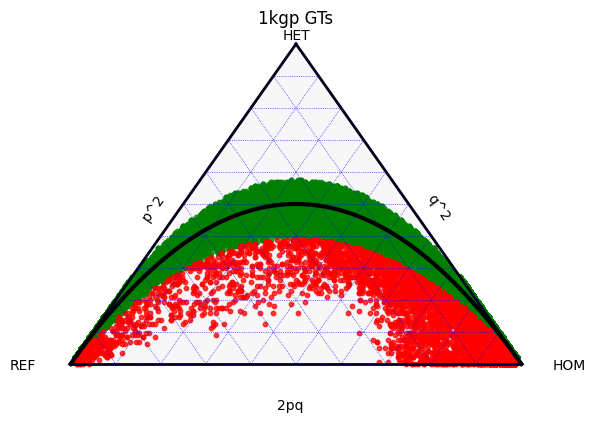

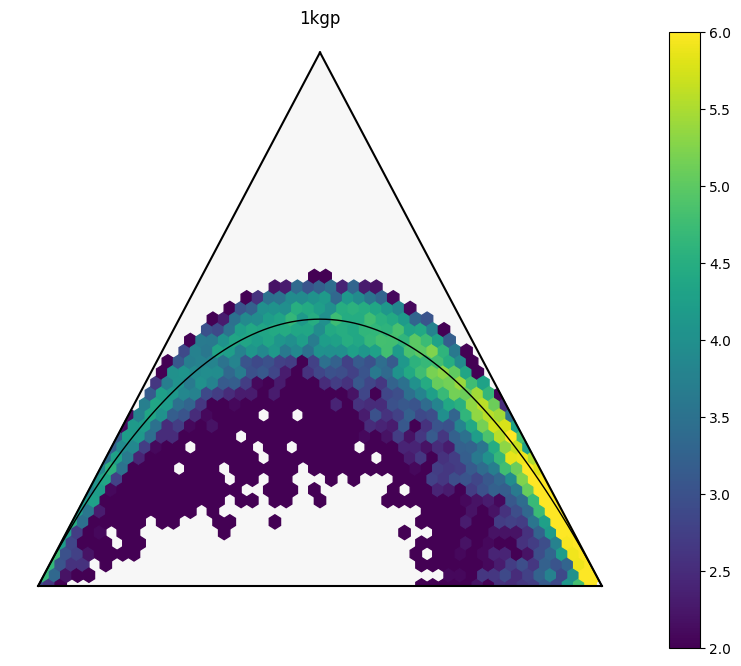

,Total,RefMon,Missing,Analyzed,PassHWE,Pass%
0,49719,0,0,49719,42957,0.863996


In [102]:
gt_snif = joblib.load("genotypes.1kgp.exchet5.eur.jl")
summary,data = hwe_ternary(gt_snif, title="1kgp GTs", alpha=0.01)
plot2(data, 50, vmin=2, vmax=6, title='1kgp', norm='log')
summary

In [126]:
parts

['genotypes/genotypes.1kgp.AFR.jl',
 'genotypes/genotypes.kanpig.AMR.jl',
 'genotypes/genotypes.kanpig.EUR.jl',
 'genotypes/genotypes.kanpig.EAS.jl',
 'genotypes/genotypes.1kgp.SAS.jl',
 'genotypes/genotypes.1kgp.EAS.jl',
 'genotypes/genotypes.kanpig.SAS.jl',
 'genotypes/genotypes.1kgp.EUR.jl',
 'genotypes/genotypes.1kgp.AMR.jl',
 'genotypes/genotypes.kanpig.AFR.jl']

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_5823/362858767.py:21: RuntimeWarning: invalid value encountered in divide
  chi = (4 * X[:, 0] * X[:, 2] - X[:, 1]**2) / (nA * nB)
/Users/english/py/lib/python3.9/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


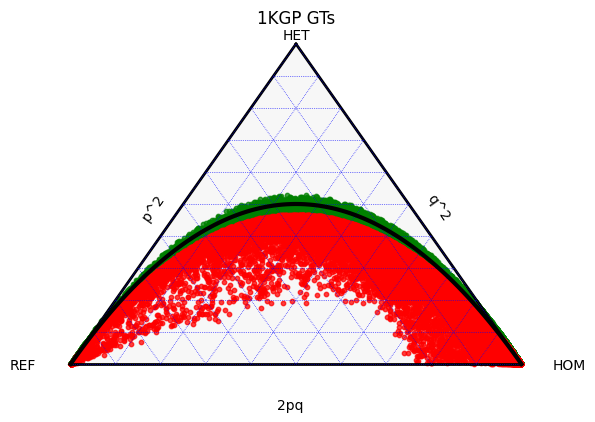

,Total,RefMon,Missing,Analyzed,PassHWE,Pass%
0,120428,648,0,119780,76229,0.636408


In [5]:
gt_snif = joblib.load("gt.1kgp.jl")
b = hwe_ternary(gt_snif, title="1KGP GTs")
b

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_1049/362858767.py:21: RuntimeWarning: invalid value encountered in divide
  chi = (4 * X[:, 0] * X[:, 2] - X[:, 1]**2) / (nA * nB)
/Users/english/py/lib/python3.9/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


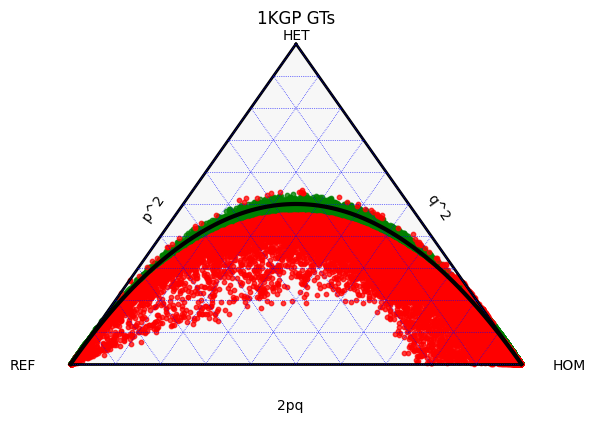

,Total,RefMon,Missing,Analyzed,PassHWE,Pass%
0,159623,648,0,158975,114186,0.718264


In [8]:
gt_snif = joblib.load("1kgp_gts.jl")
b = hwe_ternary(gt_snif, title="1KGP GTs")
b

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_1049/362858767.py:21: RuntimeWarning: invalid value encountered in divide
  chi = (4 * X[:, 0] * X[:, 2] - X[:, 1]**2) / (nA * nB)
/Users/english/py/lib/python3.9/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


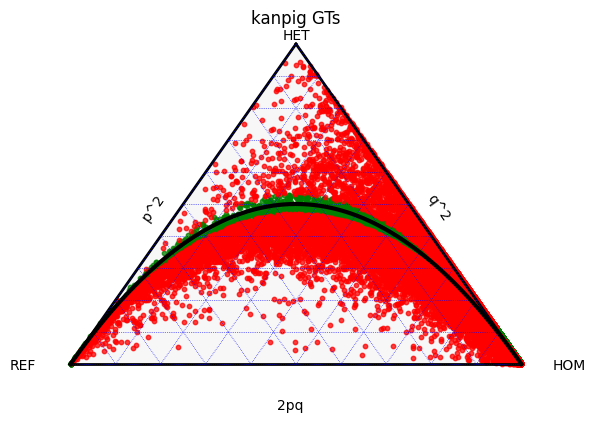

,Total,RefMon,Missing,Analyzed,PassHWE,Pass%
0,3160188,1739421,358626,1268360,1047960,0.826232


In [7]:

gt_snif = joblib.load("gtcnt_kanpig_sz.jl")
c = hwe_ternary(gt_snif, title="kanpig GTs")
c

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_1049/362858767.py:21: RuntimeWarning: invalid value encountered in divide
  chi = (4 * X[:, 0] * X[:, 2] - X[:, 1]**2) / (nA * nB)
/Users/english/py/lib/python3.9/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


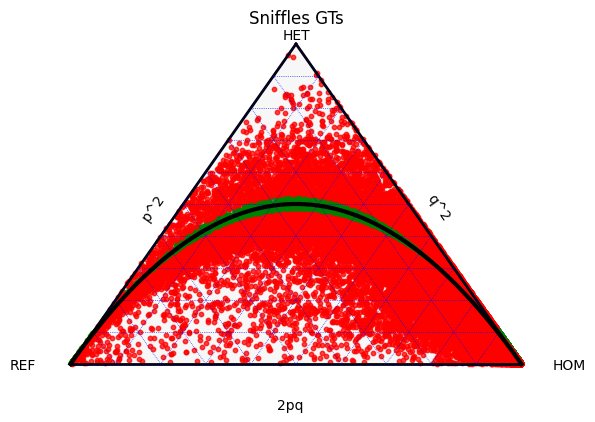

,Total,RefMon,Missing,Analyzed,PassHWE,Pass%
0,960551,13815,266691,684464,472980,0.691022


In [10]:
gt_snif = joblib.load("snif_gts.jl")
c = hwe_ternary(gt_snif, title="Sniffles GTs")
c

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_1049/362858767.py:21: RuntimeWarning: invalid value encountered in divide
  chi = (4 * X[:, 0] * X[:, 2] - X[:, 1]**2) / (nA * nB)
/Users/english/py/lib/python3.9/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


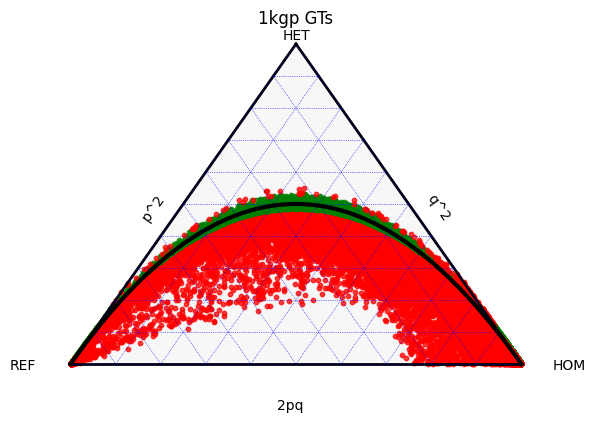

,Total,RefMon,Missing,Analyzed,PassHWE,Pass%
0,162384,648,0,161736,116722,0.721682


In [4]:
gt_snif = joblib.load("1kgp_ont_up.jl")
c = hwe_ternary(gt_snif, title="1kgp GTs")
c

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_3549/362858767.py:21: RuntimeWarning: invalid value encountered in divide
  chi = (4 * X[:, 0] * X[:, 2] - X[:, 1]**2) / (nA * nB)
/Users/english/py/lib/python3.9/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


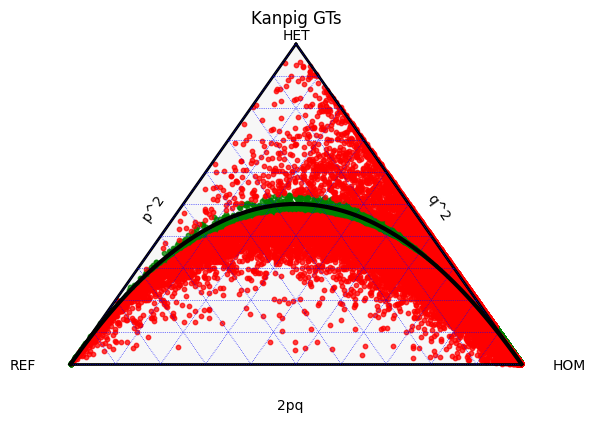

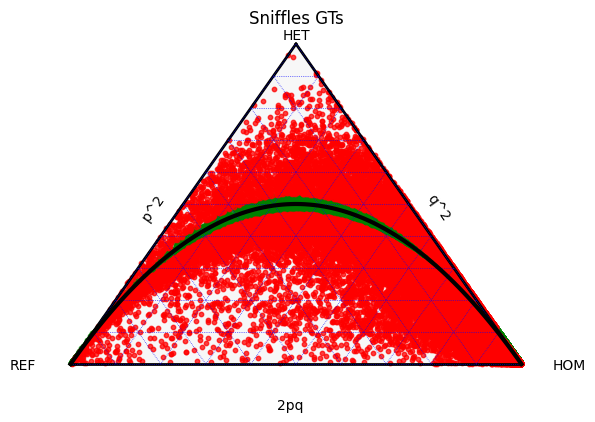

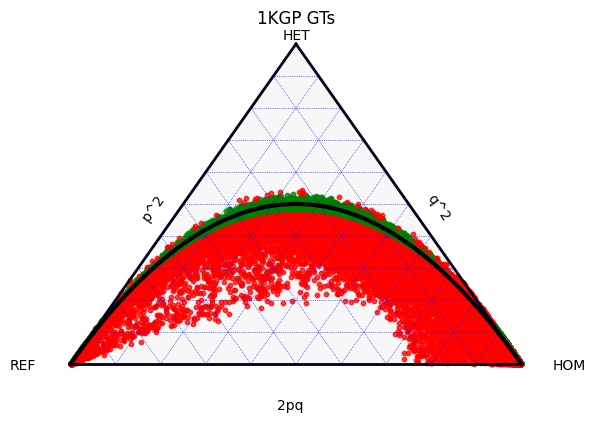

In [97]:
gt_kanpig = joblib.load("gtcnt_kanpig.jl")
a = hwe_ternary(gt, title="Kanpig GTs")

gt_snif = joblib.load("gtcnt_snifmerge.jl")
b = hwe_ternary(gt_snif, title="Sniffles GTs")

gt_1kgp = joblib.load("1kgp_ont.jl")
c = hwe_ternary(gt_1kgp, title="1KGP GTs")


In [99]:
df = pd.concat([a, b, c])
df['program'] = ['kanpig', 'sniffles', '1kgp']
df.set_index('program')

,Total,RefMon,Missing,Analyzed,PassHWE,Pass%
program,,,,,,
kanpig,3424358,2003591,622796,1268360,1047960,0.826232
sniffles,1204380,22687,396631,792606,567304,0.715745
1kgp,163466,656,0,162810,116269,0.714139


In [95]:
df

,Total,RefMon,Missing,Analyzed,PassHWE,Pass%
kanpig,3424358.0,2003591.0,622796.0,1268360.0,1047960.0,0.826232
sniffles,1204380.0,22687.0,396631.0,792606.0,567304.0,0.715745
1kgp,163466.0,656.0,0.0,162810.0,116269.0,0.714139


In [74]:
pvals = chi_sq_hwe(gt[:,:3].astype(int))
ref_mon = np.isnan(pvals)

m_tot = gt.sum(axis=1)
missing_rate = gt[:,3] / m_tot
high_missing = missing_rate >= 0.1

filt = pvals[~ref_mon & ~high_missing]

hwe_pass = (filt>=0.5).sum()

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_3549/693844934.py:21: RuntimeWarning: invalid value encountered in divide
  chi = (4 * X[:, 0] * X[:, 2] - X[:, 1]**2) / (nA * nB)


In [77]:
len(pvals), len(gt), ref_mon.sum(), missing

(3424358, 3424358, 2003591)

In [79]:
high_missing = missing_rate >= 0.1

In [80]:
high_missing.sum()

622796

In [87]:
len(pvals[~ref_mon & ~high_missing]), len(pvals[~(ref_mon | high_missing)])

(1268360, 1268360)

In [88]:
1047960/ 1268360

0.8262322999779242

In [82]:
pvals[ref_mon | high_missing]

array([nan, nan, nan, ..., nan, nan, nan])